# 0. Data and Preparation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import cv2
import random as rn
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import RMSprop

Using TensorFlow backend.


In [0]:
#setting up path for data
train_path = Path('drive/Shared drives/STA221 - Final Project/datash/train/train')
test_path = Path('drive/Shared drives/STA221 - Final Project/datash/test/test')
normal_data_path = train_path / 'NORMAL'
covid_data_path = train_path / 'COVID19 AND PNEUMONIA'

In [0]:
#resize everything to 300,300 (?)
#check later to see if we can go with other sizes
all_data=[]
all_labels=[]
for img in tqdm(os.listdir(normal_data_path)):
    path = os.path.join(normal_data_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,300))
    #if img.shape[2] ==1:
    #   img = np.dstack([img, img, img])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    #label = to_categorical(0, num_classes=2)
    all_data.append(np.array(img))
    all_labels.append(str(0))

100%|██████████| 1341/1341 [14:01<00:00,  1.59it/s]


In [0]:
#resize eveything
for img in tqdm(os.listdir(covid_data_path)):
    path = os.path.join(covid_data_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,300))
    #if img.shape[2] ==1:
    #   img = np.dstack([img, img, img])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    #label = to_categorical(0, num_classes=2)
    all_data.append(np.array(img))
    all_labels.append(str(1))

100%|██████████| 3925/3925 [22:35<00:00,  2.90it/s]


In [0]:
all_labels = np.array(all_labels)
all_data = np.array(all_data)

In [0]:
#get training and test sets (use .25 as test size)
x_train,x_test,y_train,y_test=train_test_split(all_data,all_labels,test_size=0.25,random_state=99)

In [0]:
#data augmentation?
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [0]:
test_data=[]
#all_labels=[]
for img in tqdm(os.listdir(test_path)):
    path = os.path.join(test_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,300))
    #if img.shape[2] ==1:
    #   img = np.dstack([img, img, img])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    #label = to_categorical(0, num_classes=2)
    test_data.append(np.array(img))
    #all_labels.append(str(0))

In [0]:
names=[]
for img in tqdm(os.listdir(test_path)):
  names.append(img)

100%|██████████| 690/690 [00:00<00:00, 1354901.57it/s]


In [0]:
import pandas as pd
names=pd.DataFrame(names)

# ResNet50 (Image Size: 250)

In [0]:
pip install keras-resnet

In [0]:
import keras_resnet.models

In [0]:
from tensorflow.keras import layers
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
import keras

CLASS_COUNT = 2

base_model = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(250, 250, 3), 
    pooling='avg',
)
#base_model.trainable = False
model = Sequential([
  base_model,
  Dense(CLASS_COUNT, activation='softmax'),
])
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
from keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

history = model.fit(datagen.flow(x_train,train_labels, batch_size = 32) ,epochs = 15 , validation_data = (x_test,test_labels))

Epoch 1/15
124/124 [==============================] - 108s 870ms/step - loss: 0.1250 - accuracy: 0.9514 - val_loss: 0.6320 - val_accuracy: 0.7350
Epoch 2/15


KeyboardInterrupt: ignored

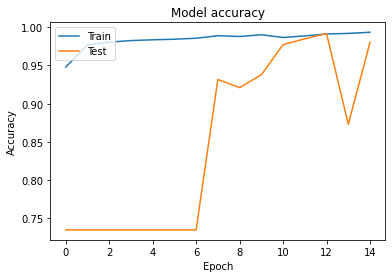

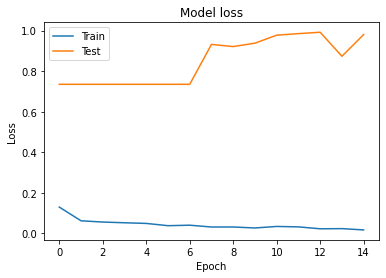

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

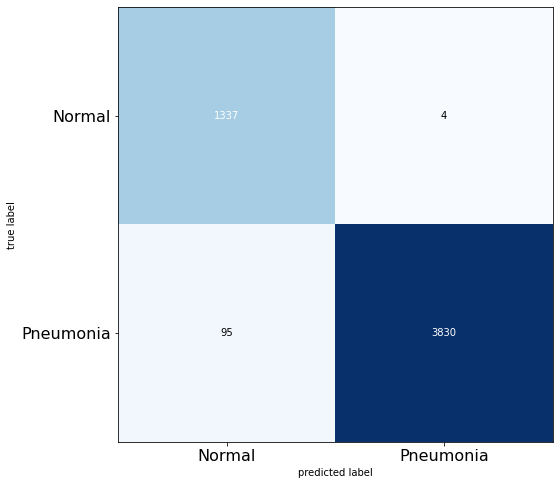

In [0]:
# All Training Set Confusion Matrix
predictions = model.predict_classes(all_data)
predictions = predictions.reshape(1,-1)[0]
predictions = np.array(list(map(str,predictions)))
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(all_labels.astype(int), predictions.astype(int))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

<Figure size 432x288 with 0 Axes>

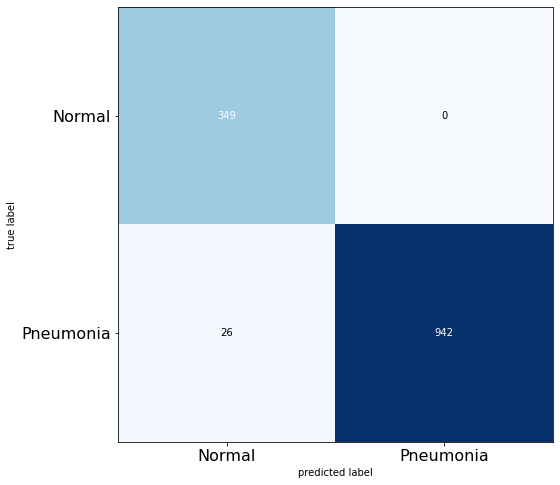

In [0]:
# Validation Set Confusion Matrix
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions = np.array(list(map(str,predictions)))
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(y_test.astype(int), predictions.astype(int))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
test_data = np.array(test_data)
predictions = model.predict_classes(test_data)
predictions = predictions.reshape(1,-1)[0]
test_labels = np.array(list(map(str,predictions)))
names['labels']=test_labels

In [0]:
import pandas as pd 
pd.DataFrame(test_labels).to_csv("/content/drive/My Drive/ResNet_label_200.csv")
pd.DataFrame(names).to_csv("/content/drive/My Drive/ResNet_label_200.csv")

# Size = 300

In [0]:
from tensorflow.keras import layers
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
import keras

CLASS_COUNT = 2

base_model = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(300, 300, 3), 
    pooling='avg',
)
#base_model.trainable = False
model = Sequential([
  base_model,
  Dense(CLASS_COUNT, activation='softmax'),
])
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
from keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

history = model.fit(datagen.flow(x_train,train_labels, batch_size = 32) ,epochs = 20 , validation_data = (x_test,test_labels))

Epoch 1/20
124/124 [==============================] - 87s 703ms/step - loss: 0.0164 - accuracy: 0.9929 - val_loss: 0.0254 - val_accuracy: 0.9909
Epoch 2/20
124/124 [==============================] - 82s 659ms/step - loss: 0.0155 - accuracy: 0.9947 - val_loss: 0.5648 - val_accuracy: 0.8504
Epoch 3/20
124/124 [==============================] - 82s 659ms/step - loss: 0.0137 - accuracy: 0.9949 - val_loss: 0.0912 - val_accuracy: 0.9757
Epoch 4/20
124/124 [==============================] - 82s 659ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.1157 - val_accuracy: 0.9643
Epoch 5/20
124/124 [==============================] - 82s 659ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 0.0357 - val_accuracy: 0.9879
Epoch 6/20
124/124 [==============================] - 82s 658ms/step - loss: 0.0233 - accuracy: 0.9929 - val_loss: 0.0907 - val_accuracy: 0.9598
Epoch 7/20
124/124 [==============================] - 82s 658ms/step - loss: 0.0180 - accuracy: 0.9929 - val_loss: 0.0208 - val_ac

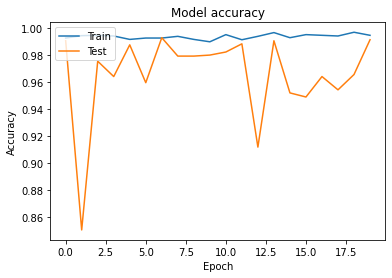

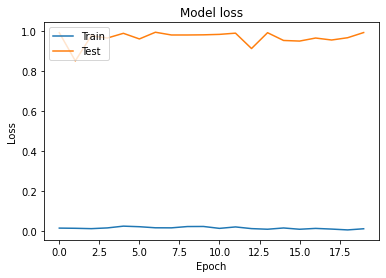

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

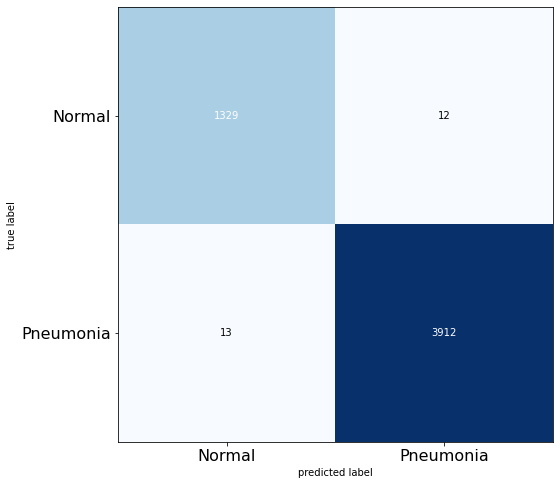

In [0]:
# All Training Set Confusion Matrix
predictions = model.predict_classes(all_data)
predictions = predictions.reshape(1,-1)[0]
predictions = np.array(list(map(str,predictions)))
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(all_labels.astype(int), predictions.astype(int))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

<Figure size 432x288 with 0 Axes>

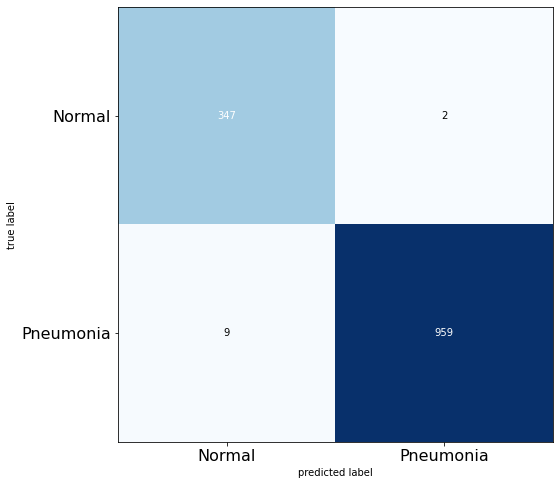

In [0]:
# Validation Set Confusion Matrix
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions = np.array(list(map(str,predictions)))
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(y_test.astype(int), predictions.astype(int))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
test_data = np.array(test_data)
predictions = model.predict_classes(test_data)
predictions = predictions.reshape(1,-1)[0]
test_labels = np.array(list(map(str,predictions)))
names['labels']=test_labels

In [0]:
import pandas as pd 
pd.DataFrame(test_labels).to_csv("/content/drive/My Drive/ResNet_labels_300.csv")
pd.DataFrame(names).to_csv("/content/drive/My Drive/ResNet_labels_300.csv")